In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [101]:
X_station_train = pd.read_csv('./Train/Train/X_station_train.csv')
X_station_train['date'] = pd.to_datetime(X_station_train['date'])
baseline_forecast_train = pd.read_csv('./Train/Train/Baselines/Baseline_forecast_train.csv')
baseline_observation_train = pd.read_csv('./Train/Train/Baselines/Baseline_observation_train.csv')
station_coords = pd.read_csv('./Other/Other/stations_coordinates.csv')
Y_train = pd.read_csv('./Train/Train/Y_train.csv')

In [102]:
X_station_train["month"] = X_station_train["date"].dt.month
X_station_train["Id_split"] = X_station_train["Id"].str.split("_")
X_station_train["hour"] = X_station_train["Id_split"].apply(lambda s: s[-1]).astype(int)
X_station_train["Id"] = X_station_train["Id_split"].apply(lambda s: s[:2]).str.join("_")
X_station_train = X_station_train.drop(columns="Id_split")

In [59]:
X_station_train["precip"] = np.log(1 + X_station_train["precip"])

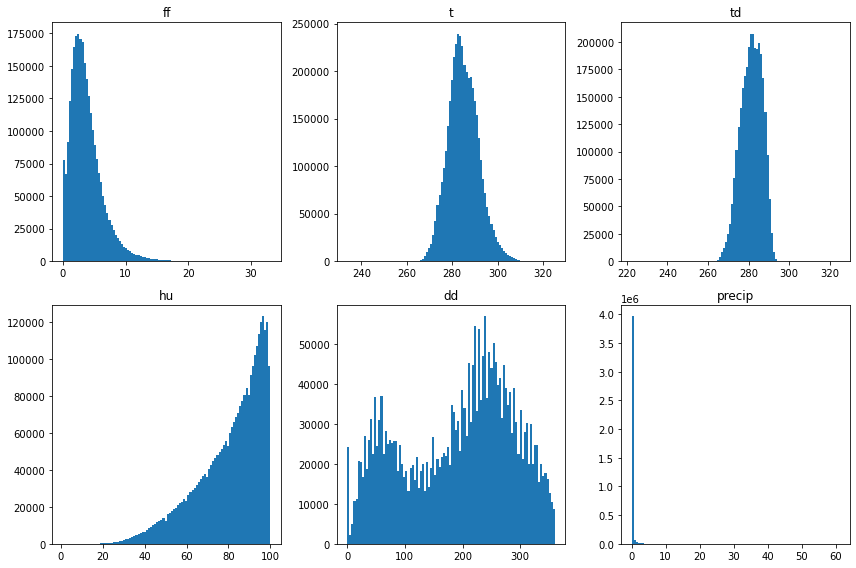

In [103]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
cols = ["ff", "t", "td", "hu", "dd", "precip", "lat", "lon", "height_sta"]
for i in range(2):
    for j in range(3):
        col = cols[3*i + j]
        ax[i,j].hist(X_station_train[col], bins=100) # standard scaler
        ax[i,j].set_title(col)

plt.tight_layout()
plt.show()

# Scale and Impute Data

In [104]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

X_station_scaler = MinMaxScaler()
X_scale_cols =  ["ff","t","td","hu","dd","precip", "month"]
X_station_train[X_scale_cols] = X_station_scaler.fit_transform(X_station_train[X_scale_cols])

In [106]:
imputer = IterativeImputer(max_iter=15, verbose=3)
imp_cols = X_scale_cols + ["hour"]
X_station_train[imp_cols] = imputer.fit_transform(X_station_train[imp_cols])
X_station_train

[IterativeImputer] Completing matrix with shape (4409474, 8)
[IterativeImputer] Ending imputation round 1/15, elapsed time 11.49
[IterativeImputer] Change: 3.361355885868719, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 2/15, elapsed time 23.12
[IterativeImputer] Change: 0.6566352576455143, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 3/15, elapsed time 34.79
[IterativeImputer] Change: 0.22380371455702164, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 4/15, elapsed time 46.41
[IterativeImputer] Change: 0.14248582444958868, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 5/15, elapsed time 58.13
[IterativeImputer] Change: 0.12442997193279626, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 6/15, elapsed time 69.70
[IterativeImputer] Change: 0.12274073603222535, scaled tolerance: 0.023 
[IterativeImputer] Ending imputation round 7/15, elapsed time 81.37
[IterativeImputer] Change: 0

C:\Users\aleks\anaconda3\envs\5gmm\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,number_sta,date,ff,t,td,hu,dd,precip,Id,month,hour
0,14066001,2016-01-01 00:00:00,0.092117,0.498302,0.543589,0.913131,0.555556,0.0,14066001_0,0.0,0.0
1,14066001,2016-01-01 01:00:00,0.077620,0.492604,0.538507,0.913131,0.527778,0.0,14066001_0,0.0,1.0
2,14066001,2016-01-01 02:00:00,0.068257,0.487236,0.534304,0.916162,0.502778,0.0,14066001_0,0.0,2.0
3,14066001,2016-01-01 03:00:00,0.079130,0.484058,0.533620,0.929293,0.441667,0.0,14066001_0,0.0,3.0
4,14066001,2016-01-01 04:00:00,0.090305,0.476827,0.531372,0.958586,0.475000,0.0,14066001_0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
4409469,95690001,2017-12-30 19:00:00,0.274841,0.579380,0.597048,0.806061,0.663889,0.0,95690001_729,1.0,19.0
4409470,95690001,2017-12-30 20:00:00,0.259136,0.576202,0.594801,0.809091,0.641667,0.0,95690001_729,1.0,20.0
4409471,95690001,2017-12-30 21:00:00,0.263969,0.574997,0.596658,0.824242,0.627778,0.0,95690001_729,1.0,21.0
4409472,95690001,2017-12-30 22:00:00,0.273029,0.574230,0.595582,0.822222,0.622222,0.0,95690001_729,1.0,22.0


In [107]:
data = Y_train[["Id", "Ground_truth"]].dropna()
for hour in tqdm(range(24)):
    X_subset = X_station_train.loc[X_station_train["hour"]==hour, ["Id", "ff","t","td","hu","dd","precip"]]
    data = pd.merge(data, X_subset, on="Id", how="inner", suffixes=["", f"_{hour}"])

data = data.rename(columns=dict(ff="ff_0", t="t_0", td="td_0", hu="hu_0", dd="dd_0", precip="precip_0"))
data = pd.merge(data, X_station_train[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")
data = pd.merge(data, baseline_observation_train[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_obs")), on="Id", how="left")
data = pd.merge(data, baseline_forecast_train[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_fore")), on="Id", how="left")
data["number_sta"] = data["Id"].str.split("_").apply(lambda s: s[0]).astype("int64")
data = pd.merge(data, station_coords, on="number_sta", how="left")
data = data.drop(columns="number_sta")

100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


In [111]:
data_scaler = MinMaxScaler()
data_scale_cols = ["pred_obs", "pred_fore", "lat", "lon", "height_sta"]
data[data_scale_cols] = data_scaler.fit_transform(data[data_scale_cols])

data_imputer = IterativeImputer(verbose=3)
imp_data_cols = data.columns[2:]
data[imp_data_cols] = data_imputer.fit_transform(data[imp_data_cols])
data

[IterativeImputer] Completing matrix with shape (162090, 150)
[IterativeImputer] Ending imputation round 1/10, elapsed time 225.85
[IterativeImputer] Change: 0.4411809169042024, scaled tolerance: 0.002418469582333546 
[IterativeImputer] Ending imputation round 2/10, elapsed time 460.15
[IterativeImputer] Change: 7.971854513316723e-13, scaled tolerance: 0.002418469582333546 
[IterativeImputer] Early stopping criterion reached.


,Id,Ground_truth,ff_0,t_0,td_0,hu_0,dd_0,precip_0,ff_1,t_1,...,td_23,hu_23,dd_23,precip_23,month,pred_obs,pred_fore,lat,lon,height_sta
0,14066001_0,3.4,0.092117,0.498302,0.543589,0.913131,0.555556,0.000000,0.077620,0.492604,...,0.559519,0.833333,0.394444,0.0,0.0,0.002139,0.076789,0.652861,0.656219,0.000000
1,14126001_0,0.5,0.083557,0.489756,0.547791,0.989899,0.469582,0.000000,0.083647,0.494686,...,0.573690,0.909091,0.543119,0.0,0.0,0.005348,0.094054,0.612511,0.723302,0.368263
2,14137001_0,3.4,0.053156,0.479457,0.533034,0.953535,0.405556,0.000000,0.104198,0.473430,...,0.565188,0.852525,0.416667,0.0,0.0,0.001104,0.088953,0.619983,0.652673,0.194611
3,14216001_0,4.0,0.055572,0.493919,0.546130,0.954545,0.625000,0.000000,0.054666,0.488003,...,0.565383,0.897980,0.472222,0.0,0.0,0.006417,0.117572,0.566183,0.696213,0.458084
4,14296001_0,13.3,0.105033,0.488660,0.551276,0.981595,0.501484,0.000000,0.104204,0.483072,...,0.554070,0.851573,0.536599,0.0,0.0,0.002139,0.361847,0.537788,0.570274,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162085,86137003_729,5.0,0.148294,0.551222,0.594801,0.942424,0.502778,0.016393,0.175174,0.554618,...,0.599296,0.830303,0.547222,0.0,1.0,0.036364,0.088189,0.162041,0.731244,0.281437
162086,86165005_729,3.2,0.149502,0.551879,0.591575,0.917172,0.577778,0.019672,0.150106,0.552536,...,0.592357,0.832323,0.613889,0.0,1.0,0.059893,0.034069,0.029035,0.836619,0.452096
162087,86272002_729,1.8,0.128745,0.547277,0.585444,0.910780,0.540777,0.019672,0.129840,0.551112,...,0.581059,0.770542,0.537125,0.0,1.0,0.059893,0.052537,0.120196,0.782159,0.353293
162088,91200002_729,1.6,0.088493,0.520324,0.567631,0.943434,0.600000,0.006557,0.072486,0.528432,...,0.594507,0.829293,0.633333,0.0,1.0,0.059893,0.068703,0.480359,1.000000,0.341317


In [114]:
data.shape

(162090, 152)